# GEOS 518: Applied Hydro Modeling
## Assignment 2: Autoregressive Models


### 1. Read in the dataset and perform any additional pre-processing needed

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.api as sm
from pandas.core import datetools
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load BOII Agrimet ET dataset
df = pd.read_csv('BOII_ET_2007to2017.csv', names=['Y','M','D','ET'], skiprows=1)
# Format a better Date column
df['Date'] = pd.to_datetime(df.Y*10000+df.M*100+df.D,format='%Y%m%d')

# Create a Water Year column in the dataframe
# 1. Create an empty array that is full of zeros and equal in length to 
#    the number of days in the record. This allocates memory for the to-be list for increased efficiency
WY = np.zeros(len(df['Y'].index)) 

# 2. For those records where the month is less than 10, their associated 
#    year is the correct water year
WY[df['M'].values < 10] = df['Y'].values[df['M'].values < 10] 

# 3. For those records where the month is greater than or equal to 10, 
#    the correct water year is one more than the current calendar year
WY[df['M'].values >= 10] = df['Y'].values[df['M'].values >= 10] + 1

# 4. Save the water year array as a column in the pandas data frame, as an
#    integer
df['WY'] = WY.astype(int)

# Print check
qrows = np.concatenate([np.arange(0,10,1),np.arange(-11,-1,1)])
df.iloc[qrows,:]

,Y,M,D,ET,Date,WY
0,2007,10,1,1.778,2007-10-01,2008
1,2007,10,2,2.286,2007-10-02,2008
2,2007,10,3,1.524,2007-10-03,2008
3,2007,10,4,1.270,2007-10-04,2008
4,2007,10,5,1.524,2007-10-05,2008
5,2007,10,6,2.286,2007-10-06,2008
6,2007,10,7,2.032,2007-10-07,2008
7,2007,10,8,3.556,2007-10-08,2008
8,2007,10,9,5.334,2007-10-09,2008
9,2007,10,10,3.302,2007-10-10,2008


### 2. Split dataset into separate "training" and "test" datasets


In [10]:
# Use the current complete dataframe and split it into two new lists
# The 'training' dataset will be all years prior to the last
# The 'test' dataset will be the last complete year to assess model accuracy
df_train = df[df.WY != 2017] # != denotes everything but the following value
df_test  = df[df.WY == 2017]

### 3. Estimate parameters of an AR model using the training dataset
    - Compute the autocorrelation function
    - Use Yule-Walker equations to estimate the AR1 parameters
    - Use the statsmodel AR tools to estimate the parameters based on the dataset

In [11]:
# ET series of training values
ET = df_train['ET'].values
ETt = pd.Series(df_train['ET'].values,df_train['Date'].values)

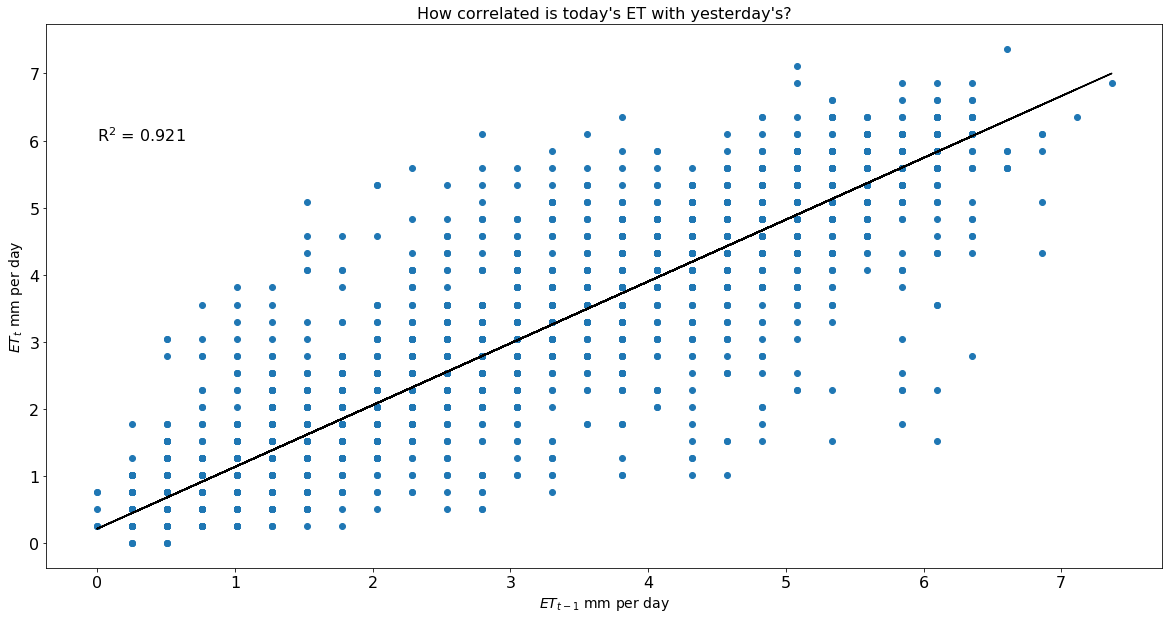

In [12]:
# Autocorrelation coeffecient (AF)
ETt   = ET[1:-1] 
ETtm1 = ET[0:-2]

# stats
R = np.corrcoef(ETtm1,ETt)
R[1,0]

# trend
z = np.polyfit(ETtm1, ETt, 1)
p = np.poly1d(z)
# plot AF
plt.figure(figsize=(20,10))
plt.plot(ETtm1,ETt,'o')
plt.plot(ETtm1,p(ETtm1),color="black")
plt.title('How correlated is today\'s ET with yesterday\'s?',fontsize=16)
plt.xlabel('$ET_{t-1}$ mm per day',fontsize=14)
plt.ylabel('$ET_t$ mm per day',fontsize=14)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
ax.annotate('R${}^2$ = %.3f'%R[0,1], xy=(0,6), fontsize=16)
plt.show()

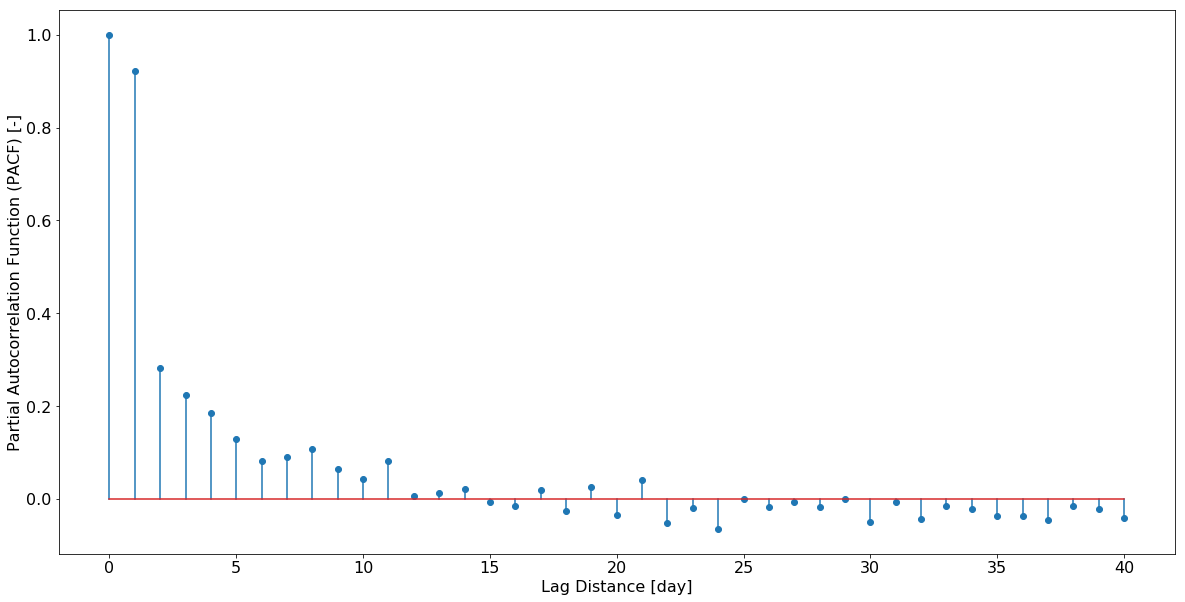

In [13]:
# Partial Autocorrelation (PACF)
# Different from the autocorrelation function (AF) which doesn't account for data lags
ETpacf = sm.pacf(ETt)
ETacf = sm.acf(ETt)

# Plot showing the PACF and the PACF from the statsmodel
plt.figure(figsize=(20,10))
plt.stem(ETpacf)
plt.ylabel('Partial Autocorrelation Function (PACF) [-]',fontsize=16)
plt.xlabel('Lag Distance [day]',fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
plt.show()

from statsmodels.graphics.tsaplots import plot_pacf
f, axarr = plt.subplots(1, 1, figsize=(20,10))
_ = plot_pacf(ETt,method='ols',lags=40,ax=axarr.axes)
axarr.set_title('Statsmodel plot of PACF',fontsize=16)
axarr.set_ylabel('Partial Autocorrelation Function (PACF) [-]',fontsize=16)
axarr.set_xlabel('Lag Distance [day]',fontsize=16)
axarr = plt.gca()
axarr.tick_params('both',labelsize=16)

### 4. Estimate parameters of an AR1 and AR2 model using the training dataset
    - Use Yule-Walker equations to estimate the AR parameters
    - Use the statsmodel AR tools to estimate the parameters based on the dataset
    - Compare the Yule-Walker parameters to those from statsmodel library

In [14]:
# AR1 Parameters based on statsmodel library
ET_AR1_model = sm.AR(ETt).fit(1) # AR1
# AR2 Parameters based on statsmodel library
ET_AR2_model = sm.AR(ETt).fit(2) # AR2

# set variables for Y.W. calculations
ETtrain = df_train['ET'].values
ETtest  = df_test['ET'].values
DatesTest = df_test['Date'].values
ETttm1 = np.concatenate([ETtrain[-2:-1], ETtest[0:-1]])
ETttm2 = np.concatenate([ETtrain[-3:-1], ETtest[0:-2]])

# Y.W. AR1 Equation variables
AR1_mu   = ET_AR1_model.params[0]
AR1_phi1 = ET_AR1_model.params[1]
# Y.W. AR1 Equation
EThatAR1 = AR1_mu + AR1_phi1*ETttm1

# Y.W. AR2 Equation variables
AR2_mu   = ET_AR2_model.params[0]
AR2_phi1 = ET_AR2_model.params[1]
AR2_phi2 = ET_AR2_model.params[2]
# Y.W. AR2 Equation
EThatAR2 = AR2_mu + AR2_phi1*ETttm1 + AR2_phi2*ETttm2

# print comparisons
print('--Statsmodel AR1--')
print(ET_AR1_model.params)
print('--Statsmodel AR2--')
print(ET_AR2_model.params)

--Statsmodel AR1--
[ 0.21365485  0.92142106]
--Statsmodel AR2--
[ 0.15398787  0.66177552  0.28176632]


### 5. Apply the AR1 and AR2 models to the "test" dataset

### 6. Plot the modeled time series for the AR1 and AR2 models against the observed time series for comparison

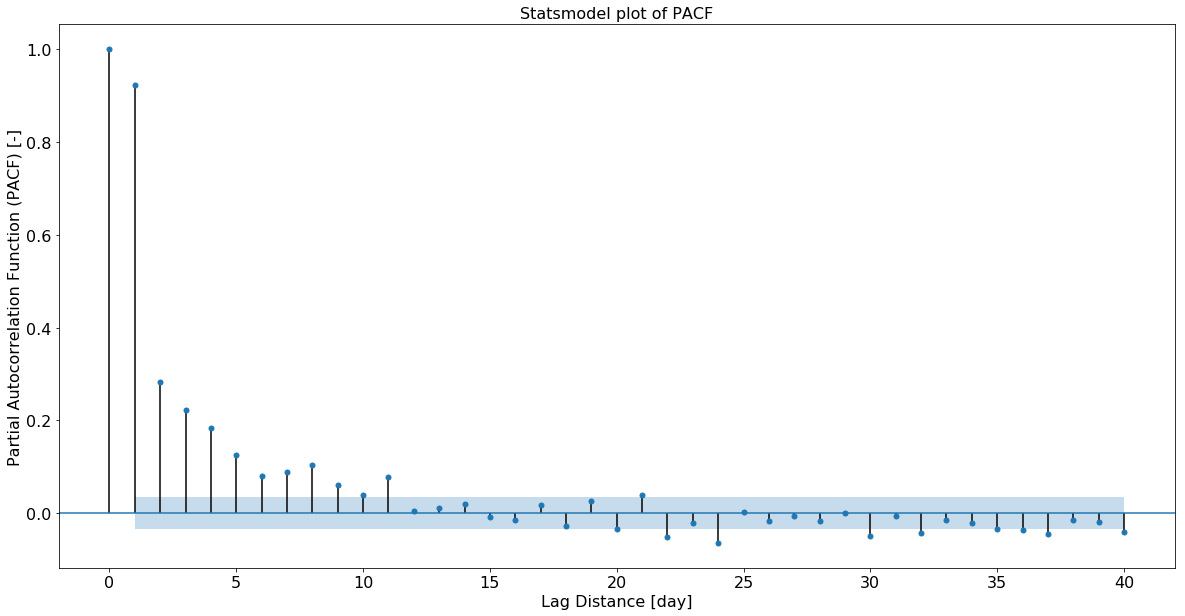

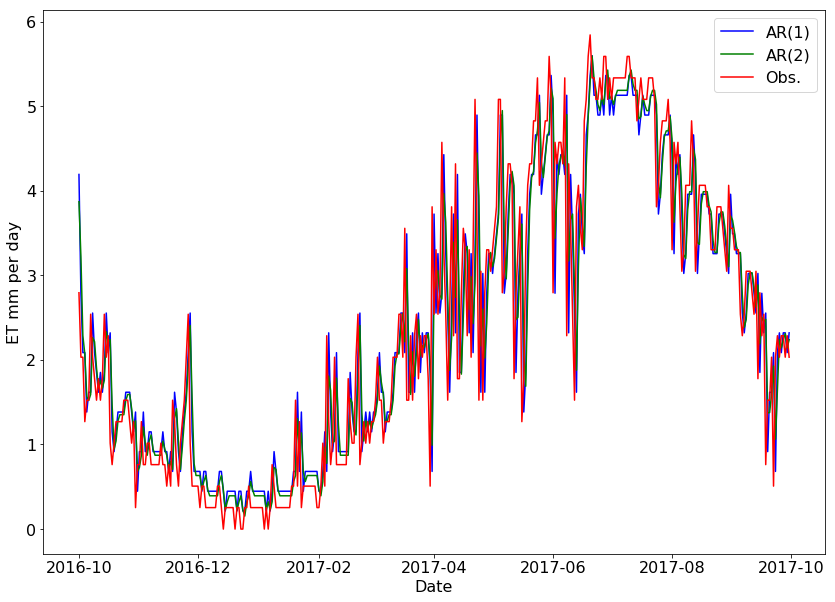

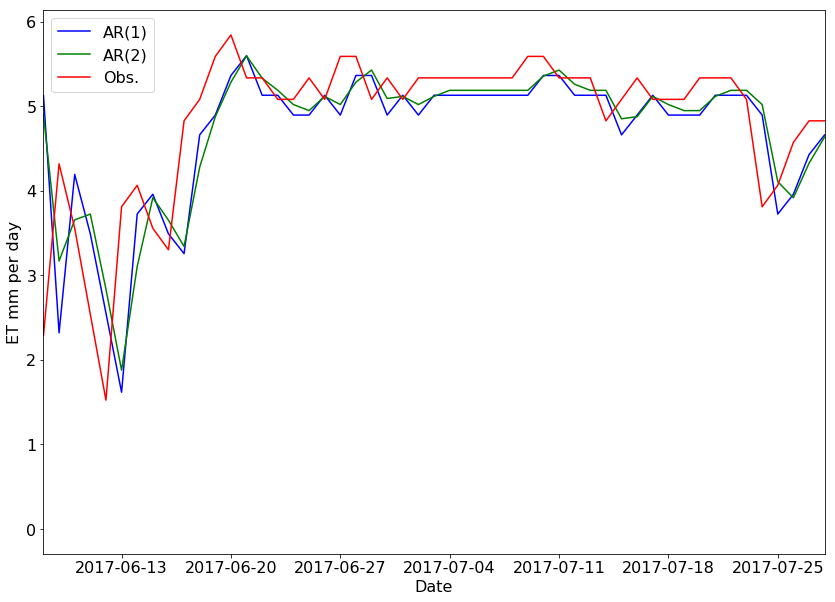

In [15]:
plt.figure(figsize=(14,10))

plt.plot(DatesTest,EThatAR1,'b-')
plt.plot(DatesTest,EThatAR2,'g-')
plt.plot(DatesTest,ETtest,'r-')
plt.ylabel('ET mm per day',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.legend(('AR(1)','AR(2)','Obs.'),fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
plt.show()

plt.figure(figsize=(14,10))
plt.plot(DatesTest,EThatAR1,'b-')
plt.plot(DatesTest,EThatAR2,'g-')
plt.plot(DatesTest,ETtest,'r-')
plt.xlim([DatesTest[250],DatesTest[300]])
plt.ylabel('ET mm per day',fontsize=16)
plt.xlabel('Date',fontsize=16)
plt.legend(('AR(1)','AR(2)','Obs.'),fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
plt.show()

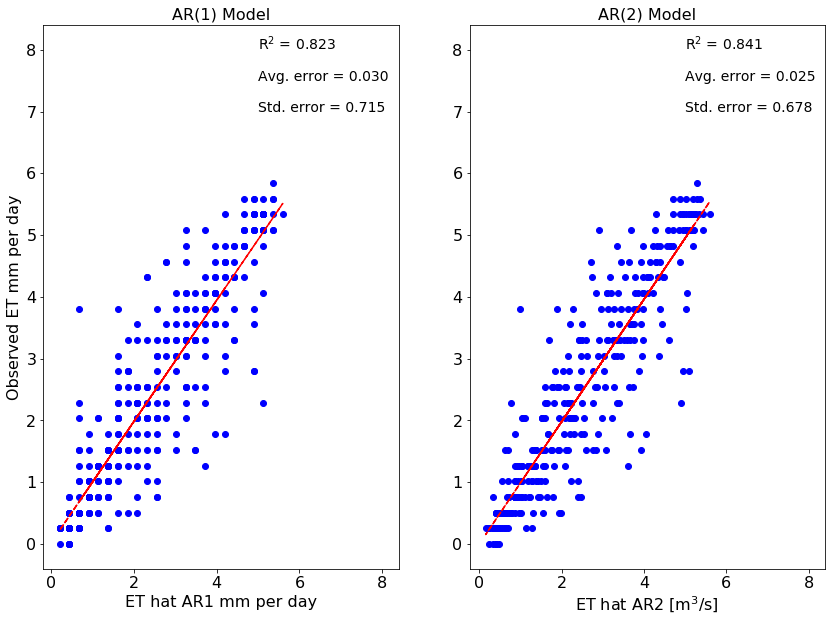

In [16]:
# Compute the R^2 values for each prediction 
R2AR1  = np.corrcoef(EThatAR1,ETtest)**2
R2AR2  = np.corrcoef(EThatAR2,ETtest)**2
muAR1  = np.mean(EThatAR1-ETtest)
stdAR1 = np.std(EThatAR1-ETtest)
muAR2  = np.mean(EThatAR2-ETtest)
stdAR2 = np.std(EThatAR2-ETtest)

# Plot the AR(1) and AR(2) model results
plt.figure(figsize=(14,10))
plt.subplot(121)
plt.plot(EThatAR1,ETtest,'bo')
plt.plot([8, 8], [8, 8], 'k-')
plt.title('AR(1) Model',fontsize=16)
plt.ylabel('Observed ET mm per day',fontsize=16)
plt.xlabel('ET hat AR1 mm per day',fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
ax.annotate('R${}^2$ = %.3f'%R2AR1[0,1], xy=(5,8), fontsize=14)
ax.annotate('Avg. error = %.3f'%muAR1, xy=(5,7.5), fontsize=14)
ax.annotate('Std. error = %.3f'%stdAR1, xy=(5,7), fontsize=14)
z = np.polyfit(EThatAR1, ETtest, 1)
p = np.poly1d(z)
plt.plot(EThatAR1,p(EThatAR1),"r--")

plt.subplot(122)
plt.plot(EThatAR2,ETtest,'bo')
plt.plot([8, 8], [8, 8], 'k-')
plt.title('AR(2) Model',fontsize=16)
plt.xlabel('ET hat AR2 [m${}^3$/s]',fontsize=16)
ax = plt.gca()
ax.tick_params('both',labelsize=16)
ax.annotate('R${}^2$ = %.3f'%R2AR2[0,1], xy=(5,8), fontsize=14)
ax.annotate('Avg. error = %.3f'%muAR2, xy=(5,7.5), fontsize=14)
ax.annotate('Std. error = %.3f'%stdAR2, xy=(5,7), fontsize=14)
z = np.polyfit(EThatAR2, ETtest, 1)
p = np.poly1d(z)
plt.plot(EThatAR2,p(EThatAR2),"r--")

plt.show()

### 7. Comment on key differences and distinctions between the models themselves and the extent to which they reproduce the observations.

The two models produce similar results, but either of them can fit slightly better in different portions of the data. They both show a clear lag in their results compared to the observed values; but that is expected as they are both functions of past data. In order to fit them in a more real time trend, you would need to add more model variables that control the constants of the equation. For this dataset, adding a scaling factor for solar radiation and precipitation would more than likely produce a much better fit line.
The AR1 model exhibits a clear time lag variation, but seems to have a more similar value(actual peak) closer to values further from the mean. Along the mean trend, AR1 values seem more inflated compared to the observed values. There are also clear points where the model is a vast undermisrepresentation. The overall fit seems alright, but with an R^2 value at .808, it seems unsuitable for a very precise future prediction of ET.
The AR2 model exhibits similar behavior to the AR1 model, with the exception of under estimating values rather than over estimating values around the data's mean. Since the AR2 model is a higher order, it seems to dampen the predicted values, outputing slightly lower than expected numbers around the mean, and very lower values around bigger data events. And as with AR1, there are also clear points where the model is a vast undermisrepresentation. With an R^2 value at 0.824, it produces a slightly better average fit than the Ar1 model.
The AR2 model is probably better suited as a representation of a typical average ET value, but is still lacking in accuracy and forecasting. Both models need more input data and scalars to really produce a reliable ET estimation.